# **[IntoAI] WEEK4 : Probablity**

##### **불확실성을 수치로 표현된 확신도를 이용해서 길들이는 방법을 살펴보며 불확실성하에서 확률론의 법칙들에 의거한 추론에 쓰이는 효율적인 네트워크 모형을 구축하는 방법을 알아본다.**

### **목차**
1. 확률 분포
2. 결합 확률 분포
3. 완전 결합 분포를 활용한 추론
4. 베이즈망
5. 베이즈망의 정확추론


*인공지능 : 현대적 접근방식(제4판)* 도서를 기반으로 작성되었으며 https://github.com/aimacode/aima-python 을 참고하였습니다.
* **Chapter12 | 불확실성의 정량화, Chapter13 | 확률적 추론** 의 내용을 포함하고 있습니다.
* 코드와 이론에 대한 자세한 설명은 (블로그 링크)를 참고하세요.
* **Google Colab**을 기반으로 작동하도록 제작되었습니다.
* notebook을 실행하기 위해서는 **probablity.py, utils.py, agents.py, notebook.py, search.py** 모듈이 포함되어야 합니다.


### **0. 기본 환경 세팅**

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 모듈이 들어있는 디렉토리로 이동하기
%cd drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 3'
/content/drive/MyDrive/TA/인공지능 입문/SCS4033_Introduce-to-AI/Week 3


In [17]:
from utils import *
from probability import *
from notebook import psource

### **1. 확률 분포**

확률 분포란, 확률 변수가 가질 수 있는 각각의 값에 어떤 확률이 배정되는 지를 결정한다. 이번 실습에서는 이런 확률 변수를 쉽게 정의하고 나타낼 수 있는 클래스를 활용하여 다양한 경우를 탐색해보고자 한다.

우선, ProbDist 클래스를 통해서 이산 확률 분포를 지정해보자. 랜덤 변수의 이름을 지정한 다음 확률을 할당할 수 있다. 딕셔너리와 유사하게 생각하면 된다. 

In [18]:
psource(ProbDist)

In [24]:
p = ProbDist('Flip')
p['H'], p['T'] = 0.25, 0.75
print(p['T'])
print(p.var_name)

0.75
Flip


`varname`을 지정해주지 않으면 **?**로 기본설정된다.
`freqs`를 통해서 딕셔너리 형태로 `{랜덤 변수 : 확률}`의 형태로 클래스를 정의할 수 있다.
그리고 `확률`란에 value로 입력된 값들을 모두 `normalized`되어 입력된 모든 value들의 합이 1인 형태로 자동 정규화된다. 

In [26]:
p = ProbDist(freq={'low': 125, 'medium': 375, 'high': 500})
print(p.var_name)

?


In [27]:
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

확률 분포 내의 모든 값을 개별적으로도 확인할 수 있다. 즉, unique한 랜덤 변수들의 값을 `values`를 통해서 확인할 수 있으며 이는 `__setitem__` 메서드에서 확인 가능하다 

In [28]:
p.values

['low', 'medium', 'high']

값들이 한번에 입력되면 자동으로 정규화를 진행하지만, 그렇지 않고 하나씩 값이 추가되면 자동으로 정규화를 하지 않는 문제가 있다. 이는 `normalize` 메서드를 활용하여 해결할 수 있다.

In [29]:
p = ProbDist('Y')
p['Cat'] = 50
p['Dog'] = 114
p['Mice'] = 64
(p['Cat'], p['Dog'], p['Mice'])

(50, 114, 64)

In [30]:
p.normalize()
(p['Cat'], p['Dog'], p['Mice'])

(0.21929824561403508, 0.5, 0.2807017543859649)

근사 값을 `show_approx` 메서드를 통해 보기 좋게 확인할 수 있다.

In [31]:
p.show_approx()

'Cat: 0.219, Dog: 0.5, Mice: 0.281'

### **2. 결합 확률 분포**

`event_values` 함수는 사건에 있는 변수 값의 튜플을 반환합니다. 하나의 사건은 딕셔너리로 지정됩니다. 여기서 key는 변수의 이름이고 값은 변수의 값입니다. 변수는 list와 함께 지정됩니다. 반환된 튜플의 순서는 변수의 순서와 동일합니다.

In [32]:
event = {'A': 10, 'B': 9, 'C': 8}
variables = ['C', 'A']
event_values(event, variables)

(8, 10)

확률 변수는 모든 랜덤 변수에 대한 결합 확률 분포로서 완전하게 결정됩니다. 확륙 모듈은 이를 `JointProbDist`라는 클래스를 통해서 구현합니다. 이 클래스는 변수 집합에 대한 이산 확률 분포를 지정합니다.

In [33]:
psource(JointProbDist)

결합 분포에 대한 값은 각 항목이 특정 변수와 연관된 값에 해당하는 순서가 지정된 튜플입니다. X, Y의 결합 분포의 경우, X와 Y는 정수값을 취합니다. 예를들어 (18, 19). 
결합 분포를 구체화하기 위해서는 우선 변수들의 list가 필요합니다.

In [34]:
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

ProbDist 클래스처럼 JointProbDist 클래스는 서로 다른 값에 대해 확률을 할당합니다. 분포의 가능한 모든 값에 대해서 두가지 형식으로 정의될 수 있습니다. 

In [35]:
j[1,1] = 0.2
j[dict(X=0, Y=1)] = 0.5

(j[1,1], j[0,1])

(0.2, 0.5)

In [36]:
j.values('X')

[1, 0]

### **3. 완전 결합 분포를 활용한 추론**

확률적 추론을 수행하는, 다시 말해 관측된 증거가 주어졌을 때 질의(query) 명제로부터 사후 확률들을 계산하는 방법을 설명한다. 이를 파이썬 딕셔너리를 사용하여 표현한다. 아래의 식은 수업시간에 다룬 식이다.

$$\textbf{P}(X | \textbf{e}) = \alpha \textbf{P}(X, \textbf{e}) = \alpha \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$

여기서 **α** 는 정규화 상수를, **X**는 질의 변수, **e**는 증거 변수들의 관측된 값들의 목록, Y를 관측되지 않은 변수들의 목록이라고 할때 이 Y 집합의 값들의 모든 가능한 조합을 **y**를 의미한다고 하자.

그리고 이를 확인하기 위해 수업시간에 사용하였던 아래의 예제를 구현해보자

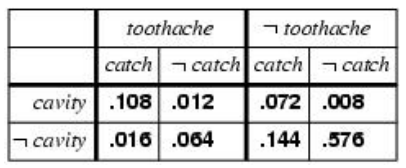

이 그림을 완전 결합 분포로 생성하면 다음과 같다

In [37]:
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576

In [38]:
psource(enumerate_joint)

P(*toothache* = True)를 찾고 싶다고 가정하자. 이는 marginalization을 통해서 얻을 수 있다. `enumerate_joint`를 통해서 이를 구해보자.

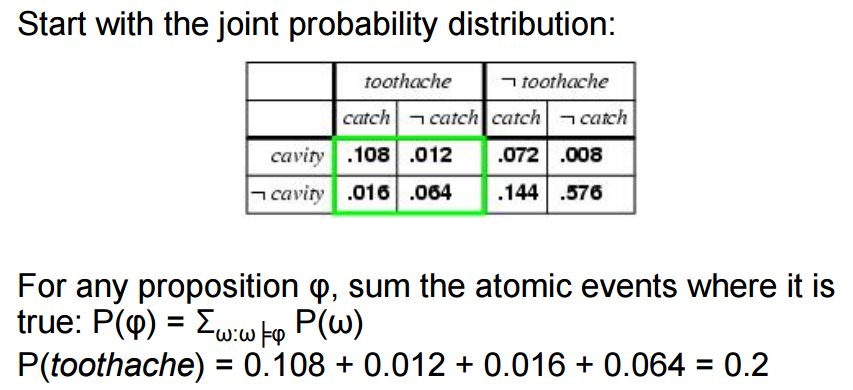

In [39]:
evidence = dict(Toothache=True)
variables = ['Cavity', 'Catch'] # variables not part of evidence
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

#Q.왜 2가 아닌 0.1999...일까? (생각해보기)

0.19999999999999998

**P(Cavity=True and Toothache=True)** 를 구하기 위해서는 아래와 같이 작성한다.

In [40]:
evidence = dict(Cavity=True, Toothache=True)
variables = ['Catch'] # variables not part of evidence
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

그리고 **P(Cavity=True | Toothache=True)**
$$P(Cavity=True | Toothache = True) = \frac{P(Cavity=True \ and \ Toothache=True)}{P(Toothache=True)}$$
와 같은 조건부 확률은 어떻게 구하면 될까? 직접 구해보자

In [ ]:
# 코드를 작성하세요


이렇게 우리는 치통이 있다는 증거가 주어졌을 때 충치의 확률을 구할 수 있었다. 그렇다면 치통이 있다는 증거가 주어졌을 때 충치가 '없을' 확률은 어떻게 구할 수 있을까? 이는 **P(toothace = True)** 가 분모에 있음을 주목하여 정규화를 활용하면 된다.

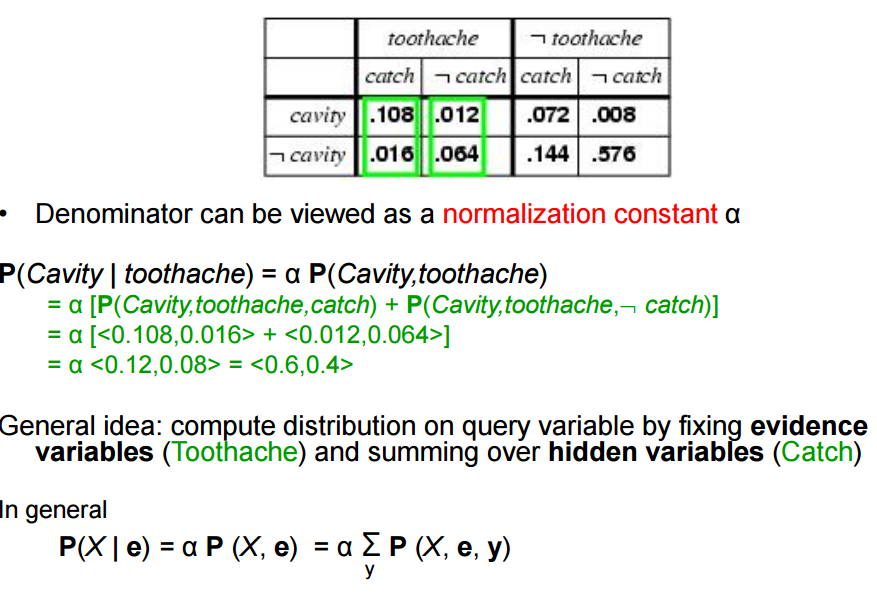

이를 구현하기 위한 코드는 아래와 같다

In [42]:
psource(enumerate_joint_ask)

함수를 활용해서 **P(Cavity | Toothache=True)** 은 어떻게 구할 수 있을까? 직접 작성해보자

In [ ]:
# 코드를 작성하세요


### **4. 베이즈망**